In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
from datetime import datetime
import joblib
import numpy as np

import emcee
from emcee import EnsembleSampler, moves

from fit2d.mcmc._likelihood import lnlike

/home/anna/anaconda3/envs/little/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
name = "UGC3974"
distance = 8000. # [kpc]
observed_2d_vel_field_fits_file = "/home/anna/Desktop/fit2d/data/UGC3974_1mom.fits"
deg_per_pixel=4.17e-4
v_systemic=270. 

ring_param_file = "/home/anna/Desktop/fit2d/data/UGC3974_ring_parameters.txt"
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape
num_bins = 1

mask_sigma=1.
random_seed = 1234
v_err_const = 10. # [km/s] per pixel constant error

# min/max bin edges to select if fitting a small number of rings
# this is combined with num_bins set above to determine the rings that will be fit
bin_min, bin_max = 3., 5.  # kpc

In [3]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic, 
)

ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

radii_to_interpolate = np.array([r for r in ring_model.radii_kpc if bin_min< r <bin_max])

In [4]:
piecewise_model = PiecewiseModel(num_bins=num_bins)
piecewise_model.set_bounds(array_bounds=np.array([(0,200), (0., np.pi), (0., np.pi)]))
piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)

prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube

In [15]:
rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}

lnlike_args = [
    piecewise_model,
    rotation_curve_func_kwargs, 
    galaxy, 
    ring_model, 
    mask_sigma
]

# mapping of ring struct params to their index in the parameters (same as specified in bounds)
# this is provided as an optional argument to lnlike to tell it which parameters to use as inc and pos_angle
fit_structural_params = {"inc": 1, "pos_angle": 2}


lnlike_args = {
    "model": piecewise_model,
    "rotation_curve_func_kwargs": rotation_curve_func_kwargs, 
    "galaxy": galaxy, 
    "ring_model": ring_model, 
    "mask_sigma": mask_sigma,
    "v_err_const": v_err_const,
    "fit_structural_params": fit_structural_params
    }


### Set the array params to some velocity, inclination, position angle, etc.

In [16]:
# This will output the value of likelihood for a given point in parameter space

# you need to provide values here
v, inc, pos_angle = 1, 1, 1   # CHANGE THESE

params = np.array([v, inc, pos_angle])  #
likelihood = lnlike(params, **lnlike_args)



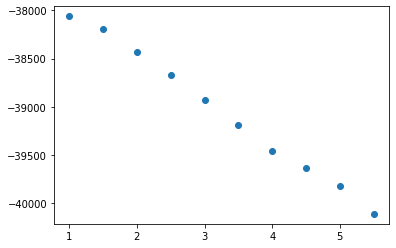

In [17]:
# To scan along a value of parameter, you can do something like

import matplotlib.pyplot as plt

# make some range of velocities over which to scan
v_range = np.array([v + i * 0.5 for i in range(10)])
lnlike_scan = []
for v in v_range:
    params = np.array([v, inc, pos_angle])
    lnlike_scan.append(lnlike(params, **lnlike_args))

plt.plot(v_range, lnlike_scan, "o")

In [20]:
lnlike(np.array([5., 1. , 1. ]), **lnlike_args)

-39821.10739650307

In [21]:
lnlike(np.array([5., 1.5 , 1. ]), **lnlike_args)

-24877.80249605232